# Model

Embedding Layer: The input embeddings (embedded tensor) are passed to the RNN layer.

RNN Layer: The code supports both LSTM and GRU with options for multiple layers and bidirectionality.

Attention Mechanism: The Attention class computes attention weights over the RNN outputs.

Context Vector: The weighted sum of the RNN outputs is computed, resulting in a context vector.

Fully Connected Layer: The context vector is passed through a fully connected layer.

Output Layer: The final output is obtained by applying a loss function (BCEWithLogitsLoss).
The BCEWithLogitsLoss function combines a sigmoid layer with the binary cross-entropy loss in a single function.

TODO: METTERE FOTO MODELLO


###  TOXIC-SENTIMENT ANALYSIS FOR LIVE CHAT
The problem we intend to address is the detection of toxic comments in online chats, with the aim of creating a predictive model capable of evaluating the presence of different kinds of toxic behaviors.

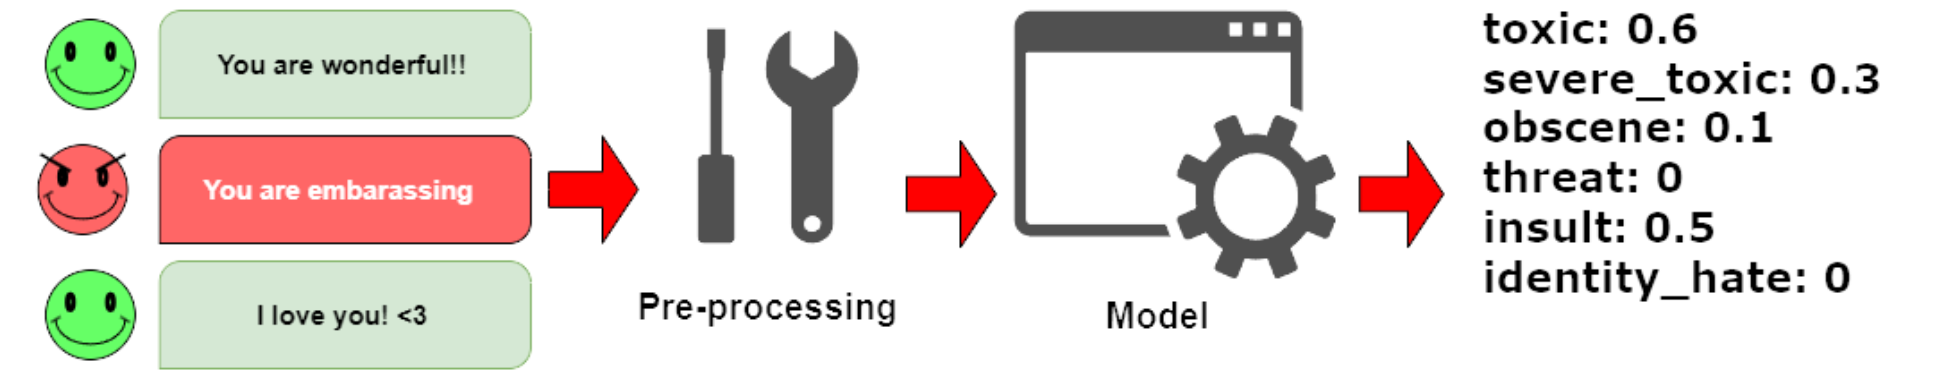

In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
# load google drive to see the files in google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# directory where we save the logs
path = '/content/drive/MyDrive/Progetto-Vascon/DataLog'

##Our Model



<h2> GET the BERT embeddings from drive

The process begins with taking a sentence asinput, to which are then applied various preprocessing techniques, such as tokenization, stemming, lemmatization, or other text cleaning pro-
cedures. The pre-processed sequence is fed to a BERT transformer, which generates token representations for each word in the sentence.

In [ ]:
import pickle
import os
import numpy as np

# Initialize lists to store combined embeddings and labels
combined_embeddings_words_train = []
combined_embedding_cls_train = []
combined_embeddings_words_val = []
combined_embedding_cls_val = []
combined_y_train = []
combined_y_val = []

for i in range(0, 3):
    # Define filenames for each of the embeddings
    file_words_train = f"embeddings_words_train__{i}.pkl"
    file_cls_train = f"embedding_cls_train__{i}.pkl"
    file_words_val = f"embeddings_words_val__{i}.pkl"
    file_cls_val = f"embedding_cls_val__{i}.pkl"

    # Load the embeddings from the specified directory
    with open(os.path.join(path, 'embeddings', file_words_train), "rb") as f:
        embeddings_words_train = pickle.load(f)
        combined_embeddings_words_train.append(embeddings_words_train)

    with open(os.path.join(path, 'embeddings', file_cls_train), "rb") as f:
        embedding_cls_train = pickle.load(f)
        combined_embedding_cls_train.append(embedding_cls_train)

    with open(os.path.join(path, 'embeddings', file_words_val), "rb") as f:
        embeddings_words_val = pickle.load(f)
        combined_embeddings_words_val.append(embeddings_words_val)

    with open(os.path.join(path, 'embeddings', file_cls_val), "rb") as f:
        embedding_cls_val = pickle.load(f)
        combined_embedding_cls_val.append(embedding_cls_val)

    y_train = np.load(os.path.join(path, 'embeddings', f'y_train_{i}.npy'))
    combined_y_train.append(y_train)

    y_val = np.load(os.path.join(path, 'embeddings', f'y_val_{i}.npy'))
    combined_y_val.append(y_val)

    print(f"Embeddings loaded successfully number {i}.")

# Concatenate lists to form the final arrays
combined_embeddings_words_train = np.concatenate(combined_embeddings_words_train, axis=0)
combined_embedding_cls_train = np.concatenate(combined_embedding_cls_train, axis=0)
combined_embeddings_words_val = np.concatenate(combined_embeddings_words_val, axis=0)
combined_embedding_cls_val = np.concatenate(combined_embedding_cls_val, axis=0)
combined_y_train = np.concatenate(combined_y_train, axis=0)
combined_y_val = np.concatenate(combined_y_val, axis=0)

print("All embeddings and labels combined successfully.")


In [ ]:
print(f"""
  combined_embeddings_words_train shape {combined_embeddings_words_train.shape}
  combined_embedding_cls_train shape {combined_embedding_cls_train.shape}
  combined_y_train shape {combined_y_train.shape} \n
  combined_embeddings_words_val shape {combined_embeddings_words_val.shape}
  combined_embedding_cls_val shape {combined_embedding_cls_val.shape}
  combined_y_val shape {combined_y_val.shape} \n
""")


  combined_embeddings_words_train shape (50881, 254, 768) 
  combined_embedding_cls_train shape (50881, 768) 
  combined_y_train shape (50881, 6) 

  combined_embeddings_words_val shape (21807, 254, 768) 
  combined_embedding_cls_val shape (21807, 768)   
  combined_y_val shape (21807, 6) 




## Training Phase
These representations from BERT
are then used as inputs for a bidirectional LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit) network, likely to capture sequential information and dependencies in the text. Afterward, an attention mechanism is performed to obtain a context vector, which is concatenated with the [CLS] tokenproduced by BERT.

In [ ]:
import torch
import torch.nn as nn
import logging
import torch
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, hamming_loss
import json
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class CustomDatasetForCLSToken(Dataset):
    def __init__(self, data, targets, cls_tokens):
        self.data = data
        self.targets = targets
        self.cls_tokens = cls_tokens

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        cls_token = self.cls_tokens[idx]

        return sample, target, cls_token

In [ ]:
custom_train_dataset = CustomDatasetForCLSToken(embeddings_words_train, y_train, embedding_cls_train)
custom_val_dataset = CustomDatasetForCLSToken(embeddings_words_val, y_val, embedding_cls_val)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        """
        Initialize the Attention mechanism.
        Args:
            hidden_dim (int): The number of expected features in the input.
        """
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attn = nn.Linear(hidden_dim, 1)
        self.init_weights()

    def init_weights(self):
        """
        Initialize weights for the attention layer.
        """
        nn.init.xavier_uniform_(self.attn.weight)
        if self.attn.bias is not None:
            nn.init.constant_(self.attn.bias, 0)

    def forward(self, rnn_output):
        """
        Forward pass for the attention mechanism.
        Args:
            rnn_output (torch.Tensor): Output from the RNN layer.
        Returns:
            torch.Tensor: Attention weights.
        """
        energy = torch.tanh(self.attn(rnn_output))
        energy = energy.squeeze(-1)
        attention_weights = F.softmax(energy, dim=1)
        return attention_weights

class SentimentClassifierWithSoftAttention(nn.Module):
    def __init__(
        self,
        embedding_dim=768,
        hidden_dim=256,
        output_dim=6,
        n_layers=1,
        bidirectional=True,
        dropout=0.0,
        rnn_type='LSTM',
    ):
        """
        Initialize the SentimentClassifierWithSoftAttention model.
        Args:
            embedding_dim (int): Dimension of the input embeddings.
            hidden_dim (int): Dimension of the hidden layer.
            output_dim (int): Dimension of the output layer.
            n_layers (int): Number of recurrent layers.
            bidirectional (bool): If True, use a bidirectional RNN.
            dropout (float): Dropout probability.
            rnn_type (str): Type of RNN to use ('LSTM' or 'GRU').
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.rnn_type = rnn_type

        self.attention = Attention(hidden_dim * 2 if bidirectional else hidden_dim)

        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                embedding_dim,
                hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout if n_layers > 1 else 0,
                batch_first=True,
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                embedding_dim,
                hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout if n_layers > 1 else 0,
                batch_first=True,
            )
        else:
            raise ValueError("Choose a valid RNN type: LSTM or GRU")

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        self.fc_cls = nn.Sequential(
            nn.Linear(hidden_dim * 2 + embedding_dim if bidirectional else hidden_dim + embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        self.init_weights()

    def init_weights(self):
        """
        Initialize weights for the RNN and fully connected layers.
        """
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

        for layer in self.fc_cls:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, embedded):
        """
        Forward pass for the model.
        Args:
            embedded (torch.Tensor): Input embeddings.
        Returns:
            torch.Tensor: Output logits.
            torch.Tensor: Attention weights.
        """
        weighted_sum, attention_weights = self.prepare_data(embedded)
        dense_outputs = self.fc(weighted_sum)
        return dense_outputs, attention_weights  # Return attention weights

    def forward_with_cls(self, embedded, cls_token):
        """
        Forward pass for the model with CLS token.
        Args:
            embedded (torch.Tensor): Input embeddings.
            cls_token (torch.Tensor): CLS token.
        Returns:
            torch.Tensor: Output logits.
            torch.Tensor: Attention weights.
        """
        weighted_sum, attention_weights = self.prepare_data(embedded)
        cls_token = cls_token.squeeze(1)
        weighted_sum_with_cls = torch.cat((weighted_sum, cls_token), dim=1) # concatenate attention weights + cls_token
        dense_outputs = self.fc_cls(weighted_sum_with_cls)
        return dense_outputs, attention_weights  # Return attention weights

    def prepare_data(self, embedded):
        """
        Prepare data by applying RNN and attention mechanism.
        Args:
            embedded (torch.Tensor): Input embeddings.
        Returns:
            torch.Tensor: Weighted sum of RNN outputs.
            torch.Tensor: Attention weights.
        """
        if len(embedded.shape) != 3:
            raise ValueError("Input shape must be 3D: (batch_size, seq_len, embedding_dim)")
        rnn_output, _ = self.rnn(embedded)
        attention_weights = self.attention(rnn_output)
        attention_weights = attention_weights.unsqueeze(1)
        weighted = torch.bmm(attention_weights, rnn_output)
        weighted_sum = weighted.squeeze(1)
        return weighted_sum, attention_weights.squeeze(1)

    def get(self):
        """
        Get model parameters as a JSON string.
        Returns:
            str: JSON string of model parameters.
        """
        params = {
            'embedding_dim': self.embedding_dim,
            'hidden_dim': self.hidden_dim,
            'output_dim': self.output_dim,
            'n_layers': self.n_layers,
            'bidirectional': self.bidirectional,
            'dropout': self.dropout,
            'rnn_type': self.rnn_type
        }
        return json.dumps(params)


In [ ]:
def calculate_metrics(predictions, targets):
    num_classes = predictions.shape[1]
    class_metrics = {i: {'true_positives': 0, 'true_negatives': 0, 'false_positives': 0, 'false_negatives': 0} for i in range(num_classes)}

    for i in range(num_classes):
        for pred, target in zip(predictions[:, i], targets[:, i]):
            if pred == 1 and target == 1:
                class_metrics[i]['true_positives'] += 1
            elif pred == 0 and target == 0:
                class_metrics[i]['true_negatives'] += 1
            elif pred == 1 and target == 0:
                class_metrics[i]['false_positives'] += 1
            elif pred == 0 and target == 1:
                class_metrics[i]['false_negatives'] += 1

    return pd.DataFrame(class_metrics).transpose()

def calculate_accuracy(metrics):
    return (metrics['true_positives'].sum()+metrics['true_negatives'].sum())/metrics.sum().sum()

def calculate_precision(metrics):

    if (metrics['true_positives'].sum() + metrics['false_positives'].sum()) >0 :
      return (metrics['true_positives'].sum())/(metrics['true_positives'].sum() + metrics['false_positives'].sum())
    else: return 0

def calculate_recall(metrics):

    if (metrics['true_positives'].sum() + metrics['false_negatives'].sum()) >0 :
      return (metrics['true_positives'].sum())/(metrics['true_positives'].sum() + metrics['false_negatives'].sum())
    else: return 0

In [ ]:
def calculate_hamming_distance(predictions, targets):
    # Ensure predictions and targets are numpy arrays
    import numpy as np
    if not isinstance(predictions, np.ndarray):
        predictions = np.array(predictions)
    if not isinstance(targets, np.ndarray):
        targets = np.array(targets)

    # Check the shape and size of predictions and targets
    assert predictions.shape == targets.shape, "Predictions and targets must have the same shape."

    # Calculate the Hamming distance
    hamming_distance = np.sum(predictions != targets)

    return hamming_distance

In [ ]:
def calculate_f1_score(precision, recall):

    # Calculate F1 score using harmonic mean of precision and recall
    if precision + recall == 0:
        return 0  # Avoid division by zero, return zero if both precision and recall are zero

    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

# Parameters

A common loss function for multi-label classification is nn.BCEWithLogitsLoss, which combines a sigmoid layer and the binary cross-entropy loss in one single class, making it numerically more stable than using a plain sigmoid followed by a BCELoss.


- nn.BCEWithLogitsLoss:

  This loss function combines a sigmoid layer and the binary cross-entropy loss in a single class.
  It is generally preferred due to its numerical stability.
  It can handle raw logits directly without needing a prior sigmoid activation.



In [ ]:
# Set hyperparameters
num_epochs = 30
learning_rate = 0.001
momentum_value = 0.75
batch_size = 128

threshold=0.7

# Define loss function
criterion = nn.BCEWithLogitsLoss()

# Define train and validation dataloaders
train_loader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(custom_val_dataset, batch_size=batch_size, shuffle=True)

<h3> DIRECTORY

In [ ]:
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir_base = os.path.join(path, current_datetime)
os.makedirs(save_dir_base, exist_ok=True)

# Training method without cls

In [ ]:

def train_model(model_rnn, optimizer, train_loader, val_loader):
  # Training loop
  num_labels = 6
  best_val_loss = float('inf')
  patience = 5  # Number of epochs to wait before stopping if no improvement
  early_stopping_counter = 0

  json_data = json.loads(model_rnn.get())
  rnn_type = json_data["rnn_type"]

  save_dir = os.path.join(save_dir_base, rnn_type)
  os.makedirs(save_dir, exist_ok=True)

  best_model_path = os.path.join(save_dir, f"best_model_{rnn_type}.pth")

  # Lists to store training and validation metrics across epochs
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  train_hamming_distance = []
  val_hamming_distance = []
  true_num_epochs = 0
  train_precision = []
  val_precision = []
  train_recall = []
  val_recall = []

  text_to_save = f"\n{rnn_type} \n"
  text_to_save += "\n ##START RUNNING \n"

  for epoch in range(num_epochs):
      model_rnn.train()
      epoch_loss = 0.0
      correct_train = [0] * num_labels
      total_train = [0] * num_labels
      true_num_epochs = true_num_epochs + 1
      predicted_embeddings =  []
      target_embeddings = []


      for batch_idx, (data, targets, _) in enumerate(train_loader):
          data, targets= data.to(device), targets.to(device)
          optimizer.zero_grad()

          # Forward pass
          outputs,_ = model_rnn.forward(data.to(dtype=torch.float32))

          # Compute loss
          loss = criterion(outputs, targets.to(dtype=torch.float32))

          # Backward pass
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

          mask = outputs >= threshold
          predicted = torch.where(mask, torch.tensor(1.0), torch.tensor(0.0))
          predicted_embeddings += [predicted]
          target_embeddings += [targets.to(dtype=torch.long)]


      predicted_embeddings_np = torch.cat(predicted_embeddings, dim=0).cpu().numpy()
      target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()

      metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
      overall_train_accuracy = calculate_accuracy(metrics)
      overall_train_precision = calculate_precision(metrics)
      overall_train_recall = calculate_recall(metrics)
      overall_train_f1_score = calculate_f1_score(overall_train_precision, overall_train_recall)
      overall_train_hamming_distance =  calculate_hamming_distance(predicted_embeddings_np,target_embeddings_np)


      print("----")
      print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.5f}, Training Hamming Distance: {overall_train_hamming_distance:.2f}")
      print("")
      text_to_save += f"\n Epoch {epoch+1}\n"
      text_to_save += f"\n Loss: {epoch_loss / len(train_loader):.5f}, Training Hamming Distance: {overall_train_hamming_distance:.2f} \n"
      text_to_save += f"\n Precision: {overall_train_precision:.2f}, Recall: {overall_train_recall:.2f}, F1_score: {overall_train_f1_score} \n"


      # Validation loop
      model_rnn.eval()
      val_loss = 0.0
      correct_val = [0] * num_labels
      total_val = [0] * num_labels
      predicted_embeddings =  []
      target_embeddings = []
      with torch.no_grad():
          for data, targets, _ in val_loader:
              data, targets = data.to(device), targets.to(device)
              #cls_tokens = cls_tokens.view(cls_tokens.shape[0], 1, cls_tokens.shape[1])

              outputs,_ = model_rnn.forward(data.to(dtype=torch.float32))
              loss = criterion(outputs, targets.to(dtype=torch.float32))
              val_loss += loss.item()

              # Calculate accuracy for each label
              mask = outputs >= threshold

              # Set values to 1 where mask is True, and to 0 where mask is False
              predicted = torch.where(mask, torch.tensor(1.0), torch.tensor(0.0))
              predicted_embeddings += [predicted]
              target_embeddings += [targets.to(dtype=torch.float32)]


      predicted_embeddings_np = torch.cat(predicted_embeddings, dim=0).cpu().numpy()
      target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()

      metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
      overall_val_accuracy = calculate_accuracy(metrics)
      overall_val_precision = calculate_precision(metrics)
      overall_val_recall = calculate_recall(metrics)
      overall_val_f1_score = calculate_f1_score(overall_val_precision, overall_val_recall)
      overall_val_hamming_distance =  calculate_hamming_distance(predicted_embeddings_np,target_embeddings_np)

      print(f"Validation Loss: {val_loss / len(val_loader):.5f}, Validation Hamming Distance: {overall_val_hamming_distance:.2f}")
      text_to_save += f"\n Validation Loss: {val_loss / len(val_loader):.5f}, Validation Hamming Distance: {overall_val_hamming_distance:.2f} \n"
      text_to_save += f"\n Precision: {overall_val_precision:.2f} , Recall: {overall_val_recall:.2f}, F1_score: {overall_val_f1_score}\n"
      text_to_save += "\n ---- \n"
      print("----")

      # Append metrics to lists
      train_losses.append(epoch_loss / len(train_loader))
      val_losses.append(val_loss / len(val_loader))
      train_accuracies.append(overall_train_accuracy)
      val_accuracies.append(overall_val_accuracy)
      train_hamming_distance.append(overall_train_hamming_distance)
      val_hamming_distance.append(overall_val_hamming_distance)
      train_precision.append(overall_train_precision)
      val_precision.append(overall_val_precision)
      train_recall.append(overall_train_recall)
      val_recall.append(overall_val_recall)

      # Check for early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          early_stopping_counter = 0
          # Save the best model
          torch.save(model_rnn.state_dict(), best_model_path)
      else:
          early_stopping_counter += 1
          if early_stopping_counter >= patience:
              print("Validation loss hasn't improved in the last", patience, "epochs. Stopping training.")
              break

  #plots
  epochs = range(1, true_num_epochs + 1)

  # Creazione di una figura e un insieme di sottoplot
  fig, axs = plt.subplots(2, 2, figsize=(10, 6))

  # images position

  axs[0, 0].plot(epochs, train_losses, label='Training Hamming Loss')
  axs[0, 0].plot(epochs, val_losses, label='Validation Hamming Loss')
  axs[0, 0].set_title('Training and Validation Loss')

  axs[0, 1].plot(epochs, train_accuracies, label='Training Accuracy')
  axs[0, 1].plot(epochs, val_accuracies, label='Validation Accuracy')
  axs[0, 1].set_title('Training and Validation Accuracy')

  axs[1, 0].plot(epochs, train_precision, label='Training Precision')
  axs[1, 0].plot(epochs, val_precision, label='Validation Precision')
  axs[1, 0].set_title('Training and Validation Precision')

  axs[1, 1].plot(epochs, train_recall, label='Training Recall')
  axs[1, 1].plot(epochs, val_recall, label='Validation Recall')
  axs[1, 1].set_title('Training and Validation Recall')

  plt.tight_layout()

  # Save the figure with all subplots as one image
  img_filename = os.path.join(save_dir, 'all_plots.png')
  plt.savefig(img_filename)
  print(f"All plots saved in one image: {img_filename}")

  # Display the figure
  plt.show()

  data = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_hamming_distance' : train_hamming_distance,
    'val_hamming_distance': val_hamming_distance,
    'train_precision': train_precision,
    'val_precision': val_precision,
    'train_recall': train_recall,
    'val_recall': val_recall
  }

  # Create DataFrame
  df = pd.DataFrame(data)
  filename_df = os.path.join(save_dir, 'metrics.csv')

  # Save DataFrame to CSV
  df.to_csv(filename_df, index=False)
  print(f"DataFrame saved to: {filename_df}")

  # Save text_to_save to a text file
  text_filename = os.path.join(save_dir, 'text_data.txt')
  with open(text_filename, 'w') as text_file:
      text_file.write(text_to_save)
  print(f"Text saved to: {text_filename}")

  return model_rnn

LSTM

----
Epoch 1, Loss: 0.06944, Training Hamming Distance: 2379.00

Validation Loss: 0.04592, Validation Hamming Distance: 729.00
----
----
Epoch 2, Loss: 0.04249, Training Hamming Distance: 1634.00

Validation Loss: 0.04196, Validation Hamming Distance: 675.00
----
----
Epoch 3, Loss: 0.04152, Training Hamming Distance: 1541.00

Validation Loss: 0.04170, Validation Hamming Distance: 643.00
----
----
Epoch 4, Loss: 0.04086, Training Hamming Distance: 1555.00

Validation Loss: 0.04159, Validation Hamming Distance: 680.00
----
----
Epoch 5, Loss: 0.03904, Training Hamming Distance: 1509.00

Validation Loss: 0.04136, Validation Hamming Distance: 652.00
----
----
Epoch 6, Loss: 0.04031, Training Hamming Distance: 1505.00

Validation Loss: 0.03998, Validation Hamming Distance: 684.00
----
----
Epoch 7, Loss: 0.03713, Training Hamming Distance: 1400.00

Validation Loss: 0.04186, Validation Hamming Distance: 698.00
----
----
Epoch 8, Loss: 0.03677, Training Hamming Distance: 1392.00

Validation 

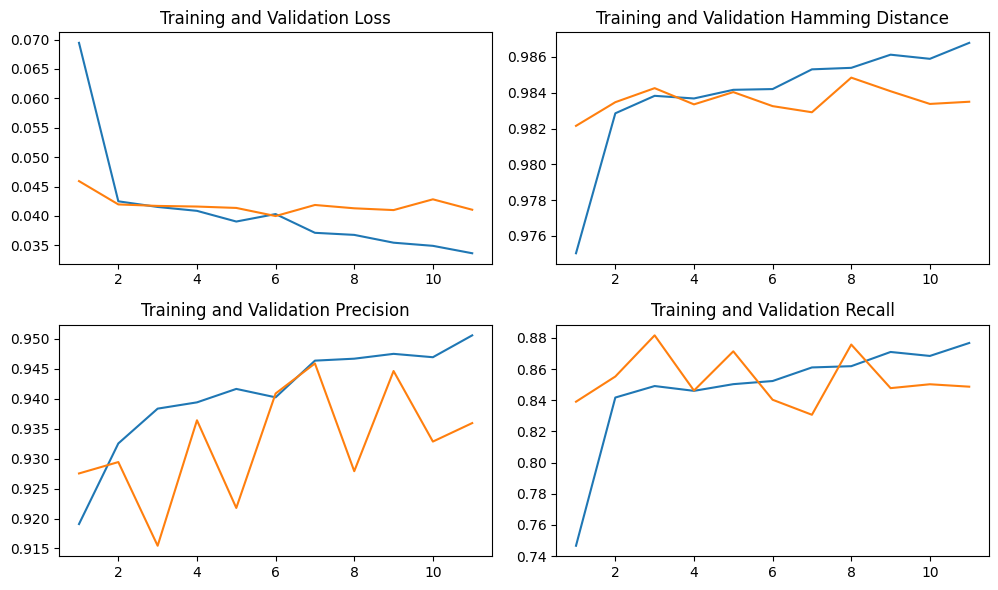

DataFrame saved to: /content/drive/MyDrive/Progetto-Vascon/DataLog/2024-07-04_08-07-28/LSTM/metrics.csv
Text saved to: /content/drive/MyDrive/Progetto-Vascon/DataLog/2024-07-04_08-07-28/LSTM/text_data.txt


In [ ]:
# 1. Initialize the model
model_rnn_lstm = SentimentClassifierWithSoftAttention(rnn_type='LSTM').to(device)
model_rnn_lstm.init_weights()

# 2. Define optimizer and loss function
optimizer = torch.optim.Adam(model_rnn_lstm.parameters(), lr=learning_rate)

# 3. Train Model
model_rnn_lstm = train_model(model_rnn_lstm, optimizer, train_loader, val_loader)

#after train it will be saved in the directory

GRU

----
Epoch 1, Loss: 0.53354, Training Hamming Distance: 7454.00

Validation Loss: 0.38256, Validation Hamming Distance: 3218.00
----
----
Epoch 2, Loss: 0.28207, Training Hamming Distance: 7454.00

Validation Loss: 0.21011, Validation Hamming Distance: 3218.00
----
----
Epoch 3, Loss: 0.17991, Training Hamming Distance: 7454.00

Validation Loss: 0.15866, Validation Hamming Distance: 3218.00
----
----
Epoch 4, Loss: 0.14784, Training Hamming Distance: 7454.00

Validation Loss: 0.13979, Validation Hamming Distance: 3218.00
----
----
Epoch 5, Loss: 0.13332, Training Hamming Distance: 7454.00

Validation Loss: 0.12765, Validation Hamming Distance: 3218.00
----
----
Epoch 6, Loss: 0.12370, Training Hamming Distance: 7454.00

Validation Loss: 0.11899, Validation Hamming Distance: 3218.00
----
----
Epoch 7, Loss: 0.11573, Training Hamming Distance: 7412.00

Validation Loss: 0.11228, Validation Hamming Distance: 3155.00
----
----
Epoch 8, Loss: 0.10928, Training Hamming Distance: 7032.00

Vali

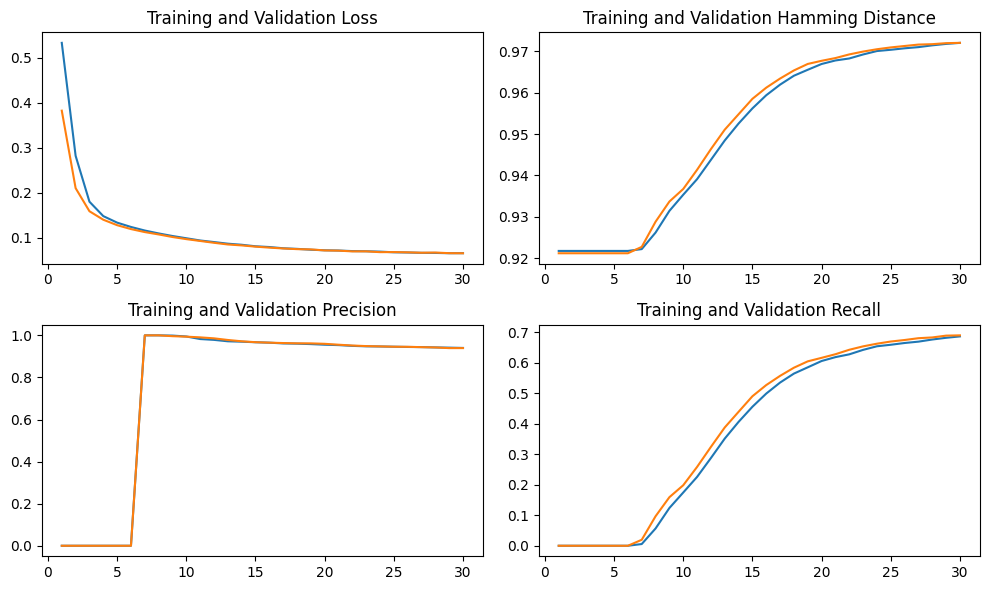

DataFrame saved to: /content/drive/MyDrive/Progetto-Vascon/DataLog/2024-07-04_08-07-28/GRU/metrics.csv
Text saved to: /content/drive/MyDrive/Progetto-Vascon/DataLog/2024-07-04_08-07-28/GRU/text_data.txt


In [ ]:
# 1. Initialize the model
model_rnn_gru = SentimentClassifierWithSoftAttention(rnn_type='GRU').to(device)
model_rnn_gru.init_weights()

# 2. Define optimizer and loss function
optimizer = torch.optim.SGD(model_rnn_gru.parameters(), lr=learning_rate, momentum=momentum_value)

# 3. Train Model
model_rnn_gru = train_model(model_rnn_gru, optimizer, train_loader, val_loader)

#after train it will be saved in the directory

# Training method with cls

In [ ]:
def train_model_cls(model_rnn, optimizer, train_loader, val_loader):
  # Training loop
  num_labels = 6
  best_val_loss = float('inf')
  patience = 5  # Number of epochs to wait before stopping if no improvement
  early_stopping_counter = 0

  json_data = json.loads(model_rnn.get())
  rnn_type = json_data["rnn_type"]

  save_dir = os.path.join(save_dir_base, f'{rnn_type}_CLS')
  os.makedirs(save_dir, exist_ok=True)

  best_model_path = os.path.join(save_dir, f"best_model_{rnn_type}_CLS.pth")

  # Lists to store training and validation metrics across epochs
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  train_hamming_distance = []
  val_hamming_distance = []
  true_num_epochs = 0
  train_precision = []
  val_precision = []
  train_recall = []
  val_recall = []

  text_to_save = f"\n{rnn_type}_CLS \n"
  text_to_save += "\n ##START RUNNING \n"


  for epoch in range(num_epochs):
      model_rnn.train()
      epoch_loss = 0.0
      correct_train = [0] * num_labels
      total_train = [0] * num_labels
      true_num_epochs = true_num_epochs + 1
      predicted_embeddings =  []
      target_embeddings = []

      for batch_idx, (data, targets, cls) in enumerate(train_loader):
          data, targets, cls = data.to(device), targets.to(device), cls.to(device)
          cls_tokens = cls.view(cls.shape[0], 1, cls.shape[1])
          optimizer.zero_grad()

          # Forward pass
          outputs,_ = model_rnn.forward_with_cls(data.to(dtype=torch.float32), cls_tokens.to(dtype=torch.float32))

          # Compute loss
          loss = criterion(outputs, targets.to(dtype=torch.float32))

          # Backward pass
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

          mask = outputs >= threshold
          predicted = torch.where(mask, torch.tensor(1.0), torch.tensor(0.0))
          predicted_embeddings += [predicted]
          target_embeddings += [targets.to(dtype=torch.long)]


      predicted_embeddings_np = torch.cat(predicted_embeddings, dim=0).cpu().numpy()
      target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()

      metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
      overall_train_accuracy = calculate_accuracy(metrics)
      overall_train_precision = calculate_precision(metrics)
      overall_train_recall = calculate_recall(metrics)
      overall_train_f1_score = calculate_f1_score(overall_train_precision, overall_train_recall)
      overall_train_hamming_distance =  calculate_hamming_distance(predicted_embeddings_np,target_embeddings_np)


      print("----")
      print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.5f}, Training Hamming Distance: {overall_train_hamming_distance:.2f}")
      print("")
      text_to_save += f"\n Epoch {epoch+1}\n"
      text_to_save += f"\n Loss: {epoch_loss / len(train_loader):.5f}, Training Hamming Distance: {overall_train_hamming_distance:.2f} \n"
      text_to_save += f"\n Precision: {overall_train_precision:.2f}, Recall: {overall_train_recall:.2f}, F1_score: {overall_train_f1_score} \n"

      # Validation loop
      model_rnn.eval()
      val_loss = 0.0
      correct_val = [0] * num_labels
      total_val = [0] * num_labels
      predicted_embeddings =  []
      target_embeddings = []
      with torch.no_grad():
          for data, targets, cls in val_loader:
              data, targets, cls = data.to(device), targets.to(device), cls.to(device)
              cls_tokens = cls.view(cls.shape[0], 1, cls.shape[1])

              outputs,_ = model_rnn.forward_with_cls(data.to(dtype=torch.float32), cls_tokens.to(dtype=torch.float32))
              loss = criterion(outputs, targets.to(dtype=torch.float32))
              val_loss += loss.item()

              # Calculate accuracy for each label
              mask = outputs >= threshold

              # Set values to 1 where mask is True, and to 0 where mask is False
              predicted = torch.where(mask, torch.tensor(1.0), torch.tensor(0.0))
              predicted_embeddings += [predicted]
              target_embeddings += [targets.to(dtype=torch.float32)]


      predicted_embeddings_np = torch.cat(predicted_embeddings, dim=0).cpu().numpy()
      target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()


      metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
      overall_val_accuracy = calculate_accuracy(metrics)
      overall_val_precision = calculate_precision(metrics)
      overall_val_recall = calculate_recall(metrics)
      overall_val_f1_score = calculate_f1_score(overall_val_precision, overall_val_recall)
      overall_val_hamming_distance =  calculate_hamming_distance(predicted_embeddings_np,target_embeddings_np)

      print(f"Validation Hamming Loss: {val_loss / len(val_loader):.5f}, Validation Hamming Distance: {overall_val_hamming_distance:.2f}")
      text_to_save += f"\n Validation Loss: {val_loss / len(val_loader):.5f}, Validation Hamming Distance: {overall_val_hamming_distance:.2f} \n"
      text_to_save += f"\n Precision: {overall_val_precision:.2f} , Recall: {overall_val_recall:.2f}, F1_score: {overall_val_f1_score}\n"
      text_to_save += "\n ---- \n"
      print("----")

      # Append metrics to lists
      train_losses.append(epoch_loss / len(train_loader))
      val_losses.append(val_loss / len(val_loader))
      train_accuracies.append(overall_train_accuracy)
      val_accuracies.append(overall_val_accuracy)
      train_hamming_distance.append(overall_train_hamming_distance)
      val_hamming_distance.append(overall_val_hamming_distance)
      train_precision.append(overall_train_precision)
      val_precision.append(overall_val_precision)
      train_recall.append(overall_train_recall)
      val_recall.append(overall_val_recall)

      # Check for early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          early_stopping_counter = 0
          # Save the best model
          torch.save(model_rnn.state_dict(), best_model_path)
      else:
          early_stopping_counter += 1
          if early_stopping_counter >= patience:
              print("Validation loss hasn't improved in the last", patience, "epochs. Stopping training.")
              break

  # Plotting
  epochs = range(1, true_num_epochs + 1)

  # Creazione di una figura e un insieme di sottoplot
  fig, axs = plt.subplots(2, 2, figsize=(10, 6))

  # images position

  axs[0, 0].plot(epochs, train_losses, label='Training Loss')
  axs[0, 0].plot(epochs, val_losses, label='Validation Loss')
  axs[0, 0].set_title('Training and Validation Loss')

  axs[0, 1].plot(epochs, train_accuracies, label='Training Accuracy')
  axs[0, 1].plot(epochs, val_accuracies, label='Validation Accuracy')
  axs[0, 1].set_title('Training and Validation Accuracy')

  axs[1, 0].plot(epochs, train_precision, label='Training Precision')
  axs[1, 0].plot(epochs, val_precision, label='Validation Precision')
  axs[1, 0].set_title('Training and Validation Precision')

  axs[1, 1].plot(epochs, train_recall, label='Training Recall')
  axs[1, 1].plot(epochs, val_recall, label='Validation Recall')
  axs[1, 1].set_title('Training and Validation Recall')

  plt.tight_layout()

  # Save the figure with all subplots as one image
  img_filename = os.path.join(save_dir, 'all_plots.png')
  plt.savefig(img_filename)
  print(f"All plots saved in one image: {img_filename}")

  # Display the figure
  plt.show()

  data = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_hamming_distance' : train_hamming_distance,
    'val_hamming_distance': val_hamming_distance,
    'train_precision': train_precision,
    'val_precision': val_precision,
    'train_recall': train_recall,
    'val_recall': val_recall
  }

  # Create DataFrame
  df = pd.DataFrame(data)
  filename_df = os.path.join(save_dir, 'metrics.csv')

  # Save DataFrame to CSV
  df.to_csv(filename_df, index=False)
  print(f"DataFrame saved to: {filename_df}")

  # Save text_to_save to a text file
  text_filename = os.path.join(save_dir, 'text_data.txt')
  with open(text_filename, 'w') as text_file:
      text_file.write(text_to_save)
  print(f"Text saved to: {text_filename}")

  return model_rnn

LSTM + CLS

----
Epoch 1, Loss: 0.27098, Training Hamming Distance: 6605.00

Validation Hamming Loss: 0.14367, Validation Hamming Distance: 2580.00
----
----
Epoch 2, Loss: 0.11746, Training Hamming Distance: 4973.00

Validation Hamming Loss: 0.10029, Validation Hamming Distance: 1754.00
----
----
Epoch 3, Loss: 0.09024, Training Hamming Distance: 3717.00

Validation Hamming Loss: 0.08233, Validation Hamming Distance: 1431.00
----
----
Epoch 4, Loss: 0.07793, Training Hamming Distance: 3104.00

Validation Hamming Loss: 0.07471, Validation Hamming Distance: 1233.00
----
----
Epoch 5, Loss: 0.07049, Training Hamming Distance: 2771.00

Validation Hamming Loss: 0.06811, Validation Hamming Distance: 1136.00
----
----
Epoch 6, Loss: 0.06658, Training Hamming Distance: 2579.00

Validation Hamming Loss: 0.06489, Validation Hamming Distance: 1068.00
----
----
Epoch 7, Loss: 0.06284, Training Hamming Distance: 2421.00

Validation Hamming Loss: 0.06193, Validation Hamming Distance: 1018.00
----
----
Epoch 8,

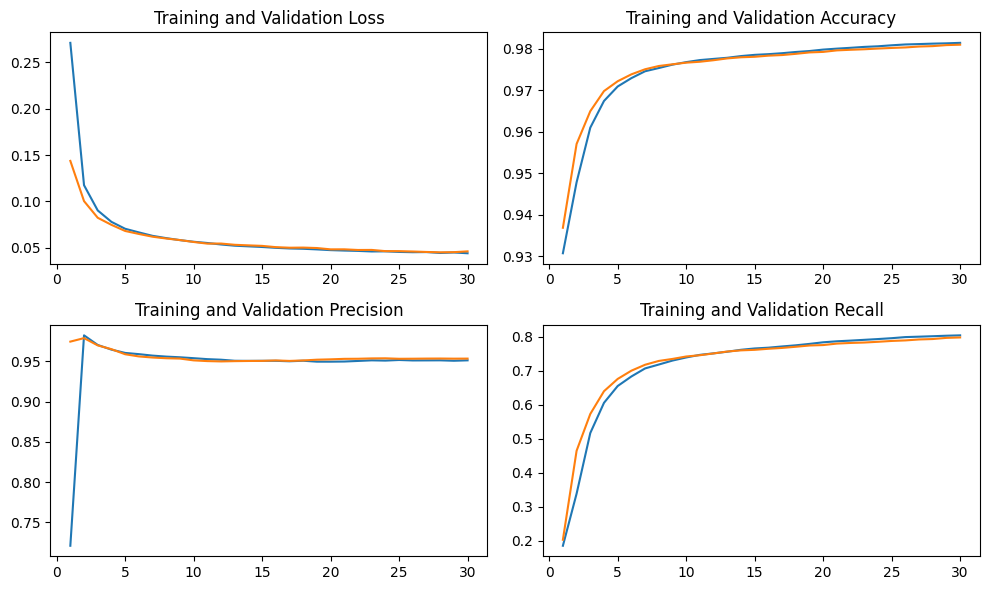

DataFrame saved to: /content/drive/MyDrive/Progetto-Vascon/DataLog/2024-07-04_08-07-28/LSTM_CLS/metrics.csv
Text saved to: /content/drive/MyDrive/Progetto-Vascon/DataLog/2024-07-04_08-07-28/LSTM_CLS/text_data.txt


In [ ]:
# 1. Initialize the model
model_rnn_lstm_cls = SentimentClassifierWithSoftAttention(rnn_type='LSTM').to(device)
model_rnn_lstm_cls.init_weights()

# 2. Define optimizer and loss function
optimizer = torch.optim.SGD(model_rnn_lstm_cls.parameters(), lr=learning_rate, momentum=momentum_value)

# 3. Train model
model_rnn_lstm_cls = train_model_cls(model_rnn_lstm_cls, optimizer, train_loader, val_loader)

#after train it will be saved in the directory

GRU + CLS

----
Epoch 1, Loss: 0.25494, Training Hamming Distance: 7825.00

Validation Hamming Loss: 0.12701, Validation Hamming Distance: 2542.00
----
----
Epoch 2, Loss: 0.10490, Training Hamming Distance: 4941.00

Validation Hamming Loss: 0.08881, Validation Hamming Distance: 1676.00
----
----
Epoch 3, Loss: 0.08157, Training Hamming Distance: 3524.00

Validation Hamming Loss: 0.07543, Validation Hamming Distance: 1315.00
----
----
Epoch 4, Loss: 0.07065, Training Hamming Distance: 2894.00

Validation Hamming Loss: 0.06704, Validation Hamming Distance: 1173.00
----
----
Epoch 5, Loss: 0.06483, Training Hamming Distance: 2613.00

Validation Hamming Loss: 0.06248, Validation Hamming Distance: 1092.00
----
----
Epoch 6, Loss: 0.06060, Training Hamming Distance: 2420.00

Validation Hamming Loss: 0.05942, Validation Hamming Distance: 1034.00
----
----
Epoch 7, Loss: 0.05804, Training Hamming Distance: 2314.00

Validation Hamming Loss: 0.05683, Validation Hamming Distance: 1000.00
----
----
Epoch 8,

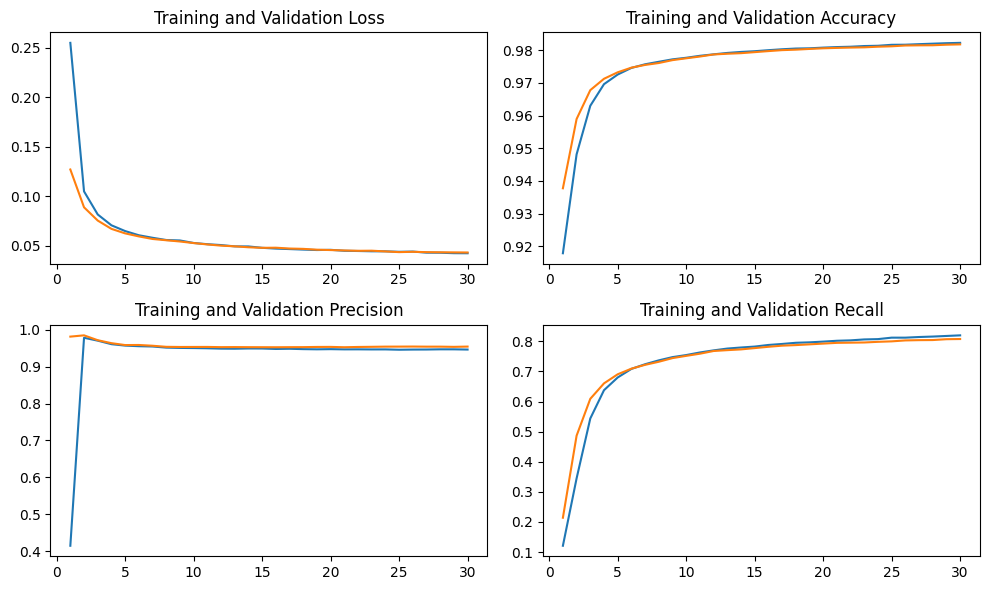

DataFrame saved to: /content/drive/MyDrive/Progetto-Vascon/DataLog/2024-07-04_08-07-28/GRU_CLS/metrics.csv
Text saved to: /content/drive/MyDrive/Progetto-Vascon/DataLog/2024-07-04_08-07-28/GRU_CLS/text_data.txt


In [ ]:
# 1. Initialize the model
model_rnn_gru_cls = SentimentClassifierWithSoftAttention(rnn_type='GRU').to(device)
model_rnn_gru_cls.init_weights()

# 2. Define optimizer and loss function
optimizer = torch.optim.SGD(model_rnn_gru_cls.parameters(), lr=learning_rate, momentum=momentum_value)

# 3. Train model
model_rnn_gru_cls = train_model_cls(model_rnn_gru_cls, optimizer, train_loader, val_loader)

#after train it will be saved in the directory

In [ ]:
num_epochs = 30
learning_rate = 0.001

# 2. Define optimizer and loss function
optimizer = torch.optim.SGD(model_rnn_gru_cls.parameters(), lr=learning_rate, momentum=momentum_value)

# 3. Train model
model_rnn_gru_cls = train_model_cls(model_rnn_gru_cls, optimizer, train_loader, val_loader)

KeyboardInterrupt: 

<h2> Test Phase

Please see another notebook